# NIST Randomness Test

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from termcolor import colored
from nistrng import *

In [265]:
img1 = cv2.imread("./outputs/fruits/fruits_cipher.png")
img2 = cv2.imread("./outputs/baboon/baboon_cipher.png")
img3 = cv2.imread("./outputs/lake/lake_cipher.png")
img4 = cv2.imread("./outputs/pepper/pepper_cipher.png")
img5 = cv2.imread("./outputs/all_zero_image/all_zero_image_cipher.png")
img6 = cv2.imread("./outputs/fruits512/fruits512_cipher.png")
img7 = cv2.imread("./outputs/fruits1024/fruits1024_cipher.png")
csv_path = "./outputs/nist_test_result"

In [266]:
if os.path.exists(csv_path):
    results_df = pd.read_csv(f"{csv_path}/nist_test_results.csv")
    pf_df = pd.read_csv(f"{csv_path}/nist_test_results_status.csv")
else:
    results_df = pd.DataFrame()
    pf_df = pd.DataFrame()

In [267]:
# @nb.njit
def run_nist_tests_and_save(binary_seq, image_name, channel_name, size):
    global results_df
    global pf_df
    eligible_battery: dict = check_eligibility_all_battery(
        binary_seq, SP800_22R1A_BATTERY
    )
    results = run_all_battery(binary_seq, eligible_battery, False)

    # Create a dictionary to hold the result for this (image, channel)
    row_data = {
        "image": image_name,
        "channel": channel_name,
        "size": size,
    }
    row2_data = {
        "image": image_name,
        "channel": channel_name,
        "size": size,
    }
    for result, elapsed_time in results:
        test_name = result.name
        test_score = np.round(result.score, 3)
        test_status = "PASSED" if result.passed else "FAILED"
        row_data[test_name] = test_score
        row2_data[test_name] = test_status

    new_result_df = pd.DataFrame([row_data])
    new_pf_df = pd.DataFrame([row2_data])
    mask = (results_df["image"] == row_data["image"]) & (
        results_df["channel"] == row_data["channel"]
    )

    if mask.any():
        # If exists, overwrite that row
        print('already exist, overwriting')
        for col in row_data:
            results_df.loc[mask, col] = row_data[col]
            pf_df.loc[mask, col] = row2_data[col]
    else:
        # Else, append the new result
        print("appending new result")
        results_df = pd.concat([results_df, new_result_df], ignore_index=True)
        pf_df = pd.concat([pf_df, new_pf_df], ignore_index=True)


In [113]:
# results_df

In [125]:
pf_df

,image,channel,Monobit,Frequency Within Block,Runs,Longest Run Ones In A Block,Binary Matrix Rank,Discrete Fourier Transform,Non Overlapping Template Matching,Maurers Universal,Serial,Approximate Entropy,Cumulative Sums,Random Excursion,Random Excursion Variant,Overlapping Template Matching,Linear Complexity,size
0,fruits,R,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,FAILED,NaN,NaN,256.0
1,fruits,G,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,FAILED,PASSED,FAILED,FAILED,PASSED,PASSED,FAILED,NaN,NaN,256.0
2,fruits,B,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,PASSED,NaN,NaN,256.0
3,baboon,R,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,PASSED,NaN,NaN,256.0
4,baboon,G,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,FAILED,NaN,NaN,256.0
5,baboon,B,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,FAILED,NaN,NaN,256.0
6,lake,R,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,FAILED,NaN,NaN,256.0
7,lake,G,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,PASSED,NaN,NaN,256.0
8,lake,B,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,FAILED,NaN,NaN,256.0
9,pepper,R,PASSED,PASSED,PASSED,PASSED,PASSED,FAILED,PASSED,PASSED,FAILED,FAILED,PASSED,PASSED,FAILED,NaN,NaN,256.0


In [115]:
def array_to_binary(flat_array):
    return np.unpackbits(flat_array)

def process_image(img, image_name):
    # If the image is colored
    if len(img.shape) == 3 and img.shape[2] == 3:
        # Split R, G, B
        R = img[:, :, 0]
        G = img[:, :, 1]
        B = img[:, :, 2]
        size = R.shape[0]

        # Flatten
        R_flat = R.flatten()
        G_flat = G.flatten()
        B_flat = B.flatten()

        # Full image as grayscale (sum of R,G,B channels)
        Full_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        Full_flat = Full_gray.flatten()

        # Convert to binary sequences
        R_bin = array_to_binary(R_flat)
        G_bin = array_to_binary(G_flat)
        B_bin = array_to_binary(B_flat)
        Full_bin = array_to_binary(Full_flat)

        # Run NIST tests
        print(colored(f"Running NIST tests for {image_name} - R channel", "yellow"))
        run_nist_tests_and_save(R_bin, image_name, "R", size)
        print(colored(f"Running NIST tests for {image_name} - G channel", "yellow"))
        run_nist_tests_and_save(G_bin, image_name, "G", size)
        print(colored(f"Running NIST tests for {image_name} - B channel", "yellow"))
        run_nist_tests_and_save(B_bin, image_name, "B", size)
        # print(colored(f"Running NIST tests for {image_name} - Full channel", "yellow"))
        # run_nist_tests_and_save(Full_bin, image_name, "Full")
    else:
        print(f"Image {image_name} is not a valid RGB image!")



In [429]:
pixel_array = np.array(img7)
pixel_values = pixel_array.flatten()
bitstream = "".join(format(pixel, "08b") for pixel in pixel_values)
bit_sequence = [int(x) for x in bitstream]

In [436]:
num_bits = 10**7
bit_seq = np.random.choice(bit_sequence, num_bits, replace=False)
bit_seq

array([0, 0, 1, ..., 1, 0, 1])

In [437]:
eligible_battery: dict = check_eligibility_all_battery(
        bit_seq, SP800_22R1A_BATTERY
    )
for test_name, is_passed in eligible_battery.items():
    print(test_name)
# test = run_by_name_battery(test_name=)

monobit
frequency_within_block
runs
longest_run_ones_in_a_block
binary_matrix_rank
dft
non_overlapping_template_matching
overlapping_template_matching
maurers_universal
linear_complexity
serial
approximate_entropy
cumulative sums
random_excursion
random_excursion_variant


In [438]:
def run_test(test_name, bit_seq):
    test_result = run_by_name_battery(
        test_name=test_name, bits=bit_seq, battery=SP800_22R1A_BATTERY
    )
    if test_result is not None:
        result, elapsed_time = test_result
        if result.passed:
            print(
                "- PASSED - score: "
                + str(np.round(result.score, 3))
                + " - "
                + result.name
                + " - elapsed time: "
                + str(elapsed_time)
                + " ms"
            )
        else:
            print(
                "- FAILED - score: "
                + str(np.round(result.score, 3))
                + " - "
                + result.name
                + " - elapsed time: "
                + str(elapsed_time)
                + " ms"
            )

    else:
        print(f"{test_name} test NOT ELIGIBLE ❌")

In [441]:
# for test_name, _ in eligible_battery.items():
#     run_test(test_name, bit_seq)

run_test("random_excursion", bit_seq)

- FAILED - score: 0.0 - Random Excursion - elapsed time: 12988 ms


In [363]:
print("Test results:")
for result, elapsed_time in results:
    if result.passed:
        print(
            "- PASSED - score: "
            + str(np.round(result.score, 3))
            + " - "
            + result.name
            + " - elapsed time: "
            + str(elapsed_time)
            + " ms"
        )
    else:
        print(
            "- FAILED - score: "
            + str(np.round(result.score, 3))
            + " - "
            + result.name
            + " - elapsed time: "
            + str(elapsed_time)
            + " ms"
        )

Test results:
- PASSED - score: 0.186 - Monobit - elapsed time: 1 ms
- PASSED - score: 0.227 - Frequency Within Block - elapsed time: 1 ms
- PASSED - score: 0.278 - Runs - elapsed time: 74 ms
- PASSED - score: 0.441 - Longest Run Ones In A Block - elapsed time: 5 ms
- PASSED - score: 0.419 - Binary Matrix Rank - elapsed time: 1279 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 15 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 621 ms
- PASSED - score: 0.02 - Maurers Universal - elapsed time: 315 ms
- FAILED - score: 0.0 - Serial - elapsed time: 8753 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 8251 ms
- PASSED - score: 1.0 - Cumulative Sums - elapsed time: 234 ms
- PASSED - score: 0.971 - Random Excursion - elapsed time: 673 ms
- FAILED - score: 0.0 - Random Excursion Variant - elapsed time: 6 ms


In [116]:
# process_image(img1, "fruits")
# process_image(img2, "baboon")
# process_image(img3, "lake")
# process_image(img4, "pepper")
process_image(img7, "fruits1024")

Running NIST tests for fruits1024 - R channel
appending new result
Running NIST tests for fruits1024 - G channel
appending new result
Running NIST tests for fruits1024 - B channel
appending new result


/opt/anaconda3/envs/cryptosystem/lib/python3.10/site-packages/nistrng/test.py:47: RuntimeWarning: Mean of empty slice
  return float(numpy.nanmean(self._score_list))


In [119]:
results_df.to_csv("outputs/nist_test_results.csv", index=False)
pf_df.to_csv("outputs/nist_test_results_status.csv", index=False)
print(colored("NIST test results saved to nist_test_results.csv", "green"))

NIST test results saved to nist_test_results.csv


## MCCM Bifurcation, phase diagram, lyapunov exponent

In [146]:
from cryptosystem import Cryptosystem
import math
import matplotlib.pyplot as plt

In [368]:
output_dir = "./outputs/mccm"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

save_path_bifurcation = os.path.join(output_dir, "bifurcation.png")
save_path_phase_trajectory = os.path.join(output_dir, "phase_trajectory.png")
save_path_lyapunov_exponent = os.path.join(output_dir, "lyapunov_exponent.png")
save_path_distribution = os.path.join(output_dir, "distribution.png")

In [ ]:
def twoDMCCM(a, b, x, y):
    x1 = np.arctan((b / (10 * a * y)) + np.tan(a * np.pi * x))
    y1 = np.arctan((b / (a * x)) + np.tan(10 * a * np.pi * y))
    return x1, y1

def icm(a,b, x_i, y_i):
    x_next = np.sin(a/y_i) * np.sin(b/x_i)
    y_next = np.sin(a/x_i) * np.sin(b/y_i)  
    return x_next, y_next

### a. bifurcation

In [314]:
import numpy as np


def licm(x, y, a, b):
    """
    Compute the next (x, y) based on the new system equations.

    Args:
        x (float): current x
        y (float): current y
        a (float): parameter a
        b (float): parameter b

    Returns:
        (float, float): next x and next y
    """
    try:
        # Small epsilon to avoid division by zero
        epsilon = 1e-10
        if abs(x) < epsilon:
            x = epsilon
        if abs(y) < epsilon:
            y = epsilon

        numerator1 = 21
        denominator1 = b * (y + 3) * a * x * (1 - a * x)
        xi_next = np.sin(numerator1 / denominator1)

        numerator2 = 21
        denominator2 = b * (a * xi_next + 3) * y * (1 - y)
        yi_next = np.sin(numerator2 / denominator2)

        return xi_next, yi_next

    except Exception as e:
        # In case of any numerical error, return NaN
        print(f"Error in licm: {e}")
        return np.nan, np.nan

In [356]:
def bifurcation_diagram(
    a_min=0.1, a_max=1, a_steps=500, iterations=2000, last=100, b=1
):
    a_values = np.linspace(a_min, a_max, a_steps)
    x1_vals = []
    y1_vals = []

    for a in a_values:
        x, y = 0.4, -0.6  # initial conditions
        for _ in range(iterations):
            x, y = twoDMCCM(x, y, a, b)
        for _ in range(last):
            x, y = twoDMCCM(x, y, a, b)
            x1_vals.append(a)
            y1_vals.append(x)

    plt.figure(figsize=(8, 6))
    plt.scatter(x1_vals, y1_vals, s=0.05, color="blue")  # Small blue dots
    plt.title("Bifurcation Diagram of 2D MCCM")
    plt.xlabel("a")
    plt.ylabel("x")
    plt.savefig(save_path_bifurcation)
    plt.show()

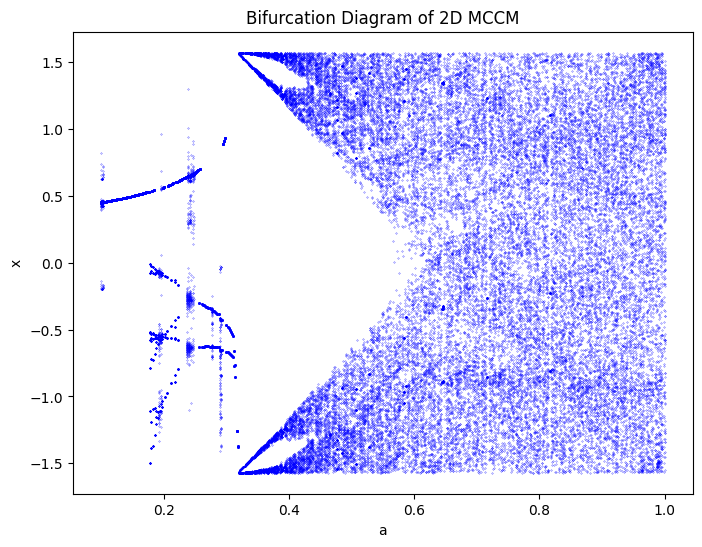

In [373]:
bifurcation_diagram()

In [372]:
import numpy as np
import matplotlib.pyplot as plt


def generate_bifurcation_data(
    map_function,
    a_min=0.0,
    a_max=1.0,
    b=21,
    a_steps=500,
    discard=500,
    keep=1000,
    x0=0.4,
    y0=0.6,
):
    a_values = np.linspace(a_min, a_max, a_steps)
    xs = []
    as_ = []

    for a in a_values:
        x, y = x0, y0
        # Discard initial iterations
        for _ in range(discard):
            x, y = map_function(x, y, a, b)

        # Store the following points
        for _ in range(keep):
            x, y = map_function(x, y, a, b)
            xs.append(x)
            as_.append(a)

    xs = np.array(xs)
    as_ = np.array(as_)
    return xs, as_


def compute_distribution(xs, as_, a_bins=5, x_bins=10):
    a_bin_edges = np.linspace(0, 1, a_bins + 1)
    x_min, x_max = np.min(xs), np.max(xs)
    x_bin_edges = np.linspace(x_min, x_max, x_bins + 1)

    distribution = np.zeros((a_bins, x_bins))

    for i in range(a_bins):
        a_start = a_bin_edges[i]
        a_end = a_bin_edges[i + 1]

        mask_a = (as_ >= a_start) & (as_ < a_end)
        xs_in_bin = xs[mask_a]

        if len(xs_in_bin) > 0:
            counts, _ = np.histogram(xs_in_bin, bins=x_bin_edges)
            distribution[i, :] = counts / np.sum(counts)  # proportion

    x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
    return x_bin_centers, distribution


def plot_stacked_bar(x_centers, distribution):
    a_labels = ["[0.0,0.2)", "[0.2,0.4)", "[0.4,0.6)", "[0.6,0.8)", "[0.8,1.0]"]
    colors = [
        "#cce5ff",
        "#99ccff",
        "#66b2ff",
        "#3399ff",
        "#007acc",
    ]  # light to dark blue

    fig, ax = plt.subplots(figsize=(10, 6))

    bottoms = np.zeros(len(x_centers))
    for i in range(distribution.shape[0]):
        ax.bar(
            x_centers,
            distribution[i],
            bottom=bottoms,
            color=colors[i],
            width=(x_centers[1] - x_centers[0]) * 0.8,
            label=f"a in {a_labels[i]}",
        )
        bottoms += distribution[i]

    ax.set_xlabel("x(i)")
    ax.set_ylabel("Proportion")
    ax.set_title("Bifurcation Value Distribution")
    ax.legend()
    plt.savefig(save_path_distribution)
    plt.tight_layout()
    plt.show()

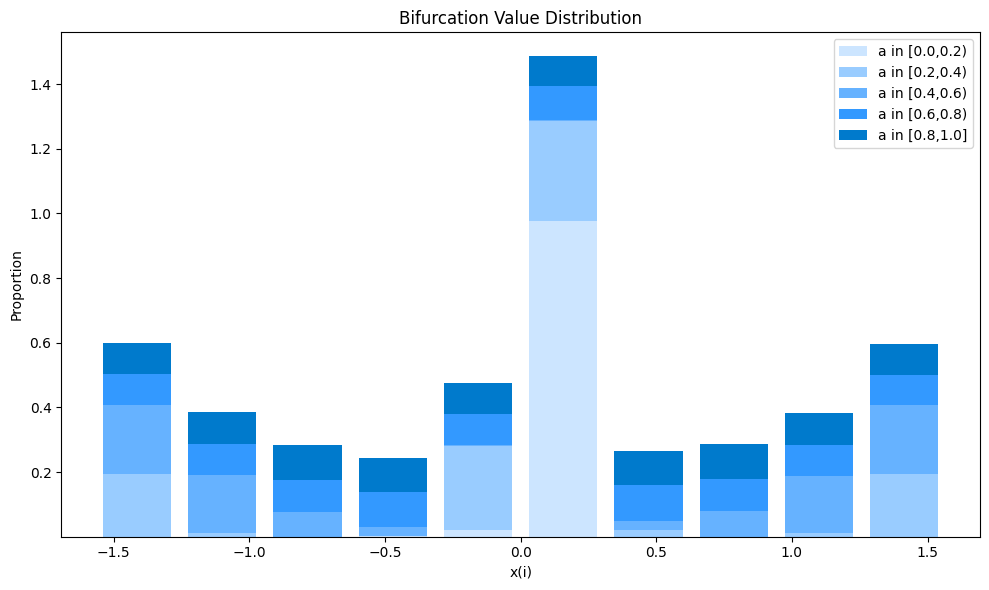

In [374]:
xs, as_ = generate_bifurcation_data(twoDMCCM)

# Compute distribution
x_centers, distribution = compute_distribution(xs, as_)

# Plot stacked bar
plot_stacked_bar(x_centers, distribution)

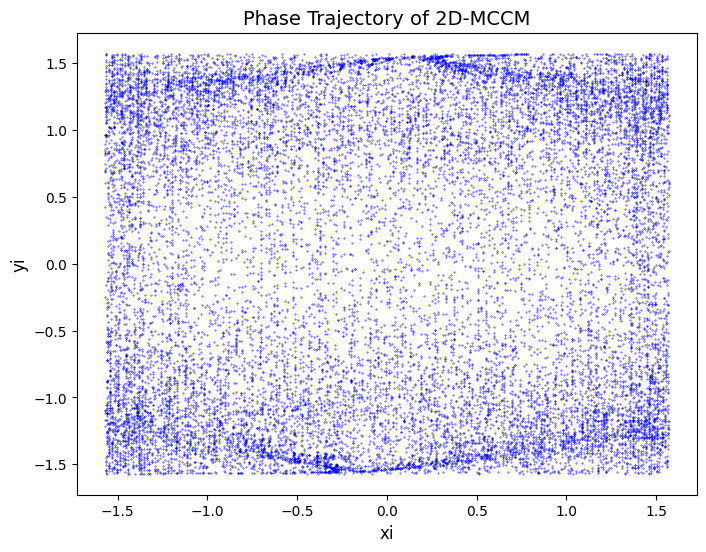

In [337]:
def phase_trajectory(a=1, b=21, total_steps=20000, save_steps=15000):
    x, y = 0.4, 0.6
    xs, ys = [], []

    for i in range(total_steps):
        x, y = twoDMCCM(x, y, a, b)
        xs.append(x)
        ys.append(y)

    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, s=0.1, color="blue")
    plt.title(f"Phase Trajectory of 2D-MCCM", fontsize=14)
    plt.xlabel("xi", fontsize=12)
    plt.ylabel("yi", fontsize=12)
    plt.savefig(save_path_phase_trajectory)
    plt.show()

phase_trajectory()

Calculating Lyapunov exponents...


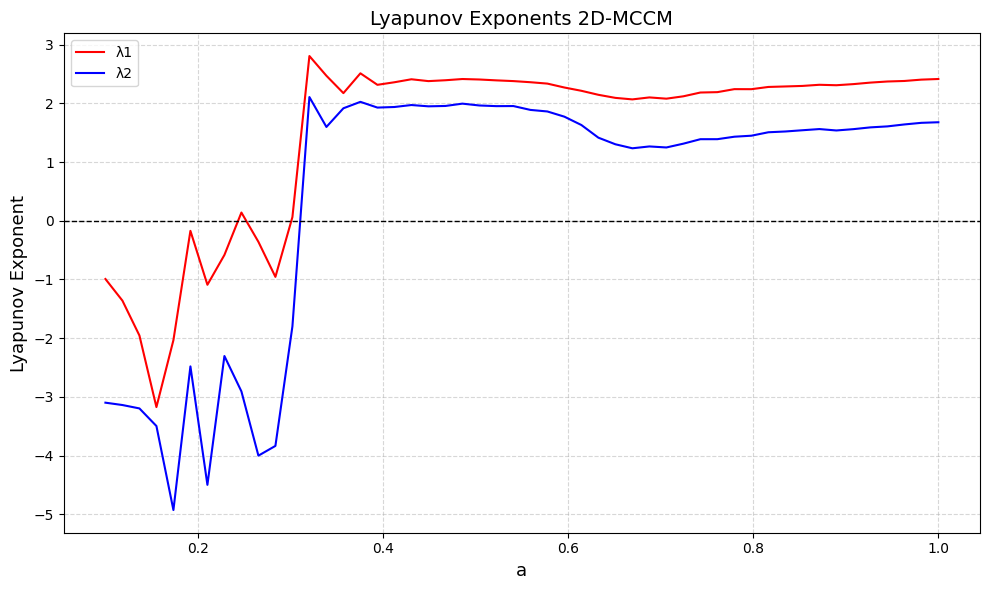

In [371]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Lyapunov Exponent Calculation Function
def lyapunov_exponents_2d_mccm(a, b=21, steps=20000, delta=1e-6):
    x, y = 0.4, 0.6
    Q = np.identity(2)
    lyap = np.zeros(2)

    for _ in range(steps):
        fx, fy = twoDMCCM(x, y, a, b)
        x_dx, _ = twoDMCCM(x + delta, y, a, b)
        _, y_dy = twoDMCCM(x, y + delta, a, b)

        dfdx = (x_dx - fx) / delta
        dfdy = (y_dy - fy) / delta
        dgdx = (twoDMCCM(x + delta, y, a, b)[1] - fy) / delta
        dgdy = (twoDMCCM(x, y + delta, a, b)[0] - fx) / delta

        J = np.array([[dfdx, dfdy], [dgdx, dgdy]])

        Z = J @ Q
        Q, R = np.linalg.qr(Z)
        lyap += np.log(np.abs(np.diag(R)))

        x, y = fx, fy

    return lyap / steps


# Sweep a from 0.001 to 1
a_values = np.linspace(0.1, 1.0, 50)  # 100 points
lambda1 = []
lambda2 = []

print("Calculating Lyapunov exponents...")
for a in a_values:
    l1, l2 = lyapunov_exponents_2d_mccm(a, b=21)
    lambda1.append(l1)
    lambda2.append(l2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(a_values, lambda1, label="λ1", color="red")
plt.plot(a_values, lambda2, label="λ2", color="blue")
plt.axhline(0, color="black", linestyle="--", lw=1)  # Horizontal line at 0
plt.title("Lyapunov Exponents 2D-MCCM", fontsize=14)
plt.xlabel("a", fontsize=13)
plt.ylabel("Lyapunov Exponent", fontsize=13)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(save_path_lyapunov_exponent)
plt.show()

In [8]:
def calculate_et_and_cpb(image_dims, times, cpu_speed_ghz=3.2):
    """
    image_dims: list of tuples (H, W) in pixels
    times: list of encryption times in seconds
    cpu_speed_ghz: CPU speed in GHz, default for Apple M1 is 3.2
    """
    cpu_speed_hz = cpu_speed_ghz * 1e9
    results = []

    for idx, (dims, t) in enumerate(zip(image_dims, times)):
        height, width = dims
        num_channels = 3  # RGB
        image_size_bytes = height * width * num_channels

        et_bps = image_size_bytes / t
        cpb = cpu_speed_hz / et_bps

        results.append(
            {
                "Image Size": f"{height}x{width}",
                "Time (s)": t,
                "ET (bytes/sec)": round(et_bps, 2),
                "CPB (cycles/byte)": round(cpb, 2),
            }
        )

    return results


# Example input for 256x256, 512x512, 1024x1024 images
image_dimensions = [(256, 256), (512, 512), (1024, 1024)]

# Replace these with your measured encryption times in seconds
encryption_times = [6.58, 25.92, 103.45]  # Example values

# Run and display results
results = calculate_et_and_cpb(image_dimensions, encryption_times)
for r in results:
    print(r)

{'Image Size': '256x256', 'Time (s)': 6.58, 'ET (bytes/sec)': 29879.64, 'CPB (cycles/byte)': 107096.35}
{'Image Size': '512x512', 'Time (s)': 25.92, 'ET (bytes/sec)': 30340.74, 'CPB (cycles/byte)': 105468.75}
{'Image Size': '1024x1024', 'Time (s)': 103.45, 'ET (bytes/sec)': 30408.2, 'CPB (cycles/byte)': 105234.78}
